In [32]:
import numpy as np
from PIL import Image
from PIL import ImageShow
import time
import torch
from torch.nn import Module, Conv2d, ReLU, MaxPool2d, Flatten, Linear, BCELoss, CrossEntropyLoss, Sequential, Sigmoid
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

CLASSES = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class0 = CLASSES.index('cat')
class1 = CLASSES.index('dog')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Model(Module):
    def __init__(self):
        super().__init__()
        self.layers = Sequential(
            Conv2d(3, 32, 3),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(32, 64, 3),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(64, 64, 4),
            ReLU(),
            Flatten(),
            Linear(576, 64),
            ReLU(),
            Linear(64, 1),
            Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

target_map = {
    class0: 0.0,
    class1: 1.0,
}
ind_test_target_map = {
    class0: 0,
    class1: 1,
}
neutral = 0.5
    
train_orig = CIFAR10('data', train=True, transform=ToTensor(), target_transform=lambda c:torch.tensor(target_map.get(c,neutral)), download=True)
indices = [i for i,t in enumerate(train_orig.targets) if t in target_map]
train_data = Subset(train_orig, indices)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)

test_data = CIFAR10('data', train=False, transform=ToTensor(), download=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

ind_test_orig = CIFAR10('data', train=False, transform=ToTensor(), target_transform=lambda c:torch.tensor(ind_test_target_map.get(c,neutral)), download=True)
indices = [i for i,t in enumerate(ind_test_orig.targets) if t in target_map]
ind_test_data = Subset(ind_test_orig, indices)
ind_test_dataloader = DataLoader(ind_test_data, batch_size=64, shuffle=False)

model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=0.004)
loss = BCELoss()
max_epochs = 30
max_minutes = 5

start_time = time.monotonic()

print(device)

# Training
for epoch in range(max_epochs):
    
    running_loss = torch.zeros(()).to(device)
    running_acc = torch.zeros(()).to(device)
    running_n = 0
    for X,targets in train_dataloader:
        X = X.to(device)
        targets = targets.to(device)
        opt.zero_grad()
        outputs = model(X)

        loss_value = loss(outputs[:,0], targets)
        loss_value.backward()
        opt.step()
        running_loss += loss_value.detach()
        running_n += X.shape[0]
        
        preds = outputs[:,0].detach() >= 0.5
        running_acc += (preds == targets).sum()
    print('Epoch', epoch, '   Loss', running_loss.item() / running_n, '    TAcc', running_acc.item() / running_n)
#    print(outputs.detach())

    if time.monotonic() - start_time > max_minutes * 60:
        print("Run out of time!")
        break
        
    with torch.no_grad():
        running_acc = torch.zeros(()).to(device)
        running_n = 0
        for X,targets in ind_test_dataloader:
            X = X.to(device)
            targets = targets.to(device)
            
            outputs = model(X)
            preds = outputs[:,0] >= 0.5
            running_acc += (preds == targets).sum()
            running_n += X.shape[0]
        print('     Accuracy', running_acc.item() / running_n)
print('Time taken', time.monotonic() - start_time, ' seconds')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 0    Loss 0.010799866456251878     TAcc 0.5348557692307693
     Accuracy 0.583
Epoch 1    Loss 0.010581433773040771     TAcc 0.5776241987179487
     Accuracy 0.5925
Epoch 2    Loss 0.010431321767660288     TAcc 0.5910456730769231
     Accuracy 0.596
Epoch 3    Loss 0.010263770054548215     TAcc 0.6145833333333334
     Accuracy 0.622
Epoch 4    Loss 0.010149689056934455     TAcc 0.6214943910256411
     Accuracy 0.5985
Epoch 5    Loss 0.009915267809843406     TAcc 0.6404246794871795
     Accuracy 0.659
Epoch 6    Loss 0.00971680421095628     TAcc 0.6529447115384616
     Accuracy 0.6755
Epoch 7    Loss 0.009606126027229505     TAcc 0.6635616987179487
     Accuracy 0.6825
Epoch 8    Loss 0.00946859747935564     TAcc 0.6655649038461539
     Accuracy 0.6725
Epoch 9    Loss 0.009334387687536387     TAcc 0.6834935897435898
     Accuracy 0.686
Epoch 10    Loss 0.0091211

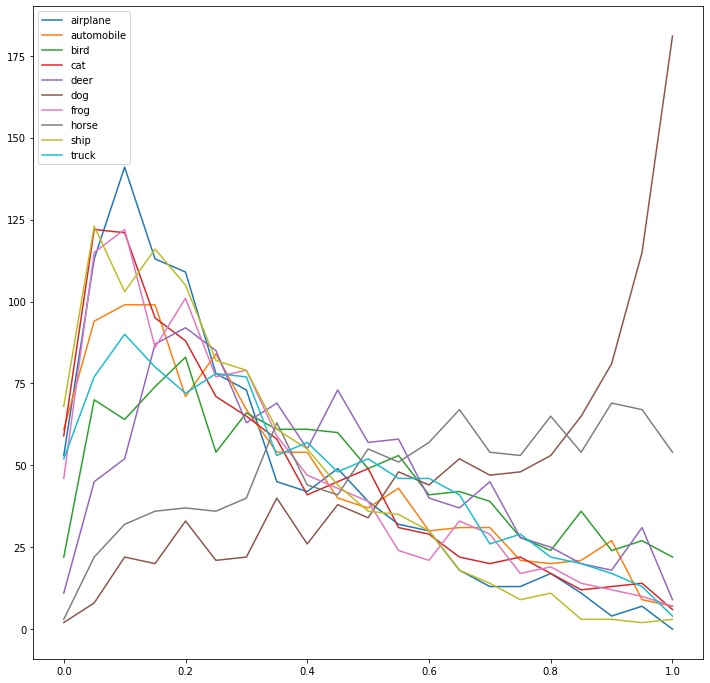

In [33]:
from matplotlib import pyplot as plt

with torch.no_grad():
    probs = np.zeros((len(test_data),))
    targets = np.zeros((len(test_data),))
    i = 0
    for X,y in test_dataloader:
        X = X.to(device)
        j = i + X.shape[0]
        probs[i:j] = model(X)[:,0].to('cpu').numpy()
        targets[i:j] = y
        i = j

    plt.rcParams['figure.figsize'] = [12, 12]
    for i,label in enumerate(CLASSES):
        samples = probs.compress(targets==i, axis=0)
        h, _ = np.histogram(samples, bins=21, range=(0,1))
        plt.plot(np.arange(21)/20, h, label=label)
    plt.legend()

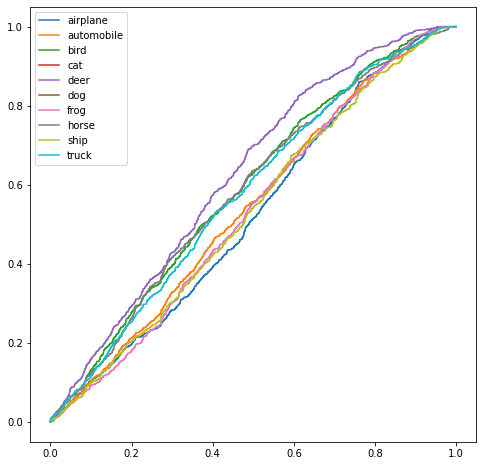

In [34]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

with torch.no_grad():
    scores = np.zeros((len(test_data),))
    targets = np.zeros((len(test_data),))
    oods = np.zeros((len(test_data),), 'bool')
    i = 0
    for X,y in test_dataloader:
        X = X.to(device)
        j = i + X.shape[0]
        probs = model(X)[:,0].to('cpu').numpy()
        scores[i:j] = np.minimum(probs, 1 - probs)
        targets[i:j] = y
        oods[i:j] = (y != class0) & (y != class1)
        i = j

    plt.rcParams['figure.figsize'] = [8, 8]
    for i,label in enumerate(CLASSES):
        if i == class0 or i == class1:
            # ROC curve doesn't make sense for the in-distribution classes
            plt.plot([], [], label=label)
        else:
            keep = (targets == i) | ~oods
            y_true = oods.compress(keep, axis=0)
            y_score = scores.compress(keep, axis=0)
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            plt.plot(fpr, tpr, label=label)
    plt.legend()